# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [183]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [184]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [185]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

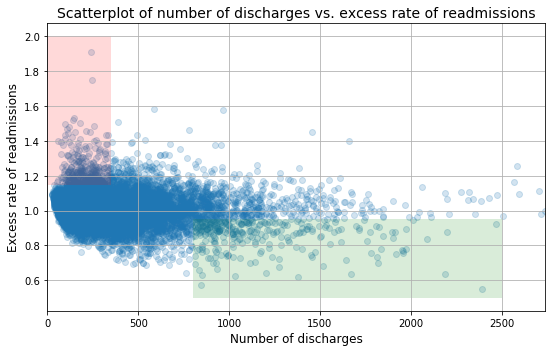

In [186]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
<div class="span5 alert alert-info">
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

A. Do you agree with the above analysis and recommendations? Why or why not?
   
B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

   1. Setup an appropriate hypothesis test.
   2. Compute and report the observed significance value (or p-value).
   3. Report statistical significance for $\alpha$ = .01. 
   4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?
   5. Look at the scatterplot above. 
      - What are the advantages and disadvantages of using this plot to convey information?
      - Construct another plot that conveys the same information in a more direct manner.



You can compose in notebook cells using Markdown: 
+ In the control panel at the top, choose Cell > Cell Type > Markdown
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
</div>
****

In [187]:
# Your turn

The visual inspection of the chart produced seem to confirm the conclusion that the rate of readmission is shrinking with the increasing size of the hospital, number of discharges specifically. 

However, the mean excess readmission rate does not provide on its own any information about statistical significance. Without proper analysis, it's impossible to tell whether the reported different in means is "a lot" or not.

Start with measuring statistically significance of the difference in means of rate of readmission. 

In [188]:
# packages we're gonna be using
import numpy
import math

In [189]:
ratio_metric = 'Excess Readmission Ratio'
discharges_metric = 'Number of Discharges'

In [190]:
# custom implementation of the z-score calculation
# https://en.wikipedia.org/wiki/Standard_score
def z_score(value, mean, std, sample_size):
    signal = value - mean
    noise = std / numpy.sqrt(sample_size - 1)
    return signal / noise

In [191]:
# helper function to plot scatter plots
def create_scatter(x, y, s = 20):
    fig, ax = plt.subplots(figsize=(8,5))
    ax.scatter(x, y, s=s, alpha=0.2)

    ax.set_xlim([min(x), max(x)])
    ax.set_xlabel('Number of discharges', fontsize=12)
    ax.set_ylabel('Excess rate of readmissions', fontsize=12)
    ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

    ax.grid(True)
    fig.tight_layout()

In [192]:
def subset_hospitals(hospitals, max_discharges = float("inf"), min_discharges = 0):
    hospital_subset = hospitals[(hospitals[discharges_metric] > min_discharges) & (hospitals[discharges_metric] < max_discharges)]
    return hospital_subset

In [193]:
# abstract calculation of z score for a subset of hospital 
# so that we can calculate it for different groups
def calculate_hospital_z_score(hospitals, hospital_subset):
    # convert lists to numpy array so that we can get statistical properties
    all_array = numpy.array(hospitals[ratio_metric])
    subset_array = numpy.array(hospital_subset[ratio_metric])
    
    # calculate z score
    z = z_score(subset_array.mean(), all_array.mean(), subset_array.std(), len(all_array))
    
    # plot scatter with results
    create_scatter(hospital_subset[discharges_metric], hospital_subset[ratio_metric])
    
    return z

In [194]:
# some of the hospitals don't have readmission rate and are unusable for the analysis
def clean_hospitals(hospitals):
    return hospitals[hospitals[ratio_metric] > 0]

## 1. Setup an appropriate hypothesis test.

*Null hypothesis*: there isn't any difference in the readmission rate of small hospitals any hospitals on average

*Alternative hypothesis*: small hospitals have significantly different readmission rate

## 2. Compute and report the observed significance value (or p-value).

Hospitals under 100 z-score: 27.9630273637
Hospitals under 300 z-score: 8.75528856918
STD of the entire sample: 0.0919602664563


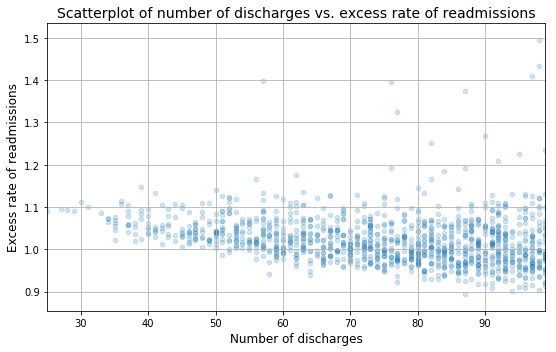

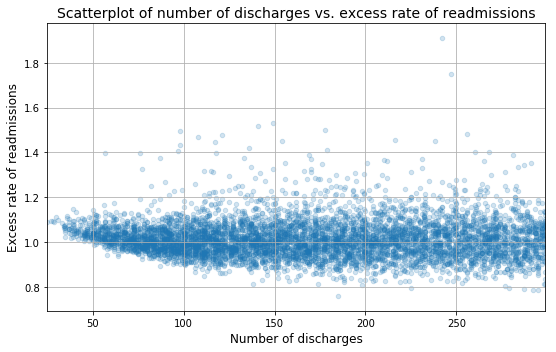

In [195]:
# create copy of the initial data frame
hospitals = clean_hospital_read_df

# get the usable ones
hospitals = clean_hospitals(hospitals)

# compute z score for hospitals under 100 discharges
very_small_hospitals = subset_hospitals(hospitals, 100)
very_small_hospitals_z_score = calculate_hospital_z_score(hospitals,very_small_hospitals)
print 'Hospitals under 100 z-score: {0}'.format(very_small_hospitals_z_score)

# compute z score for hospitals under 300 discharges
small_hospitals = subset_hospitals(hospitals, 300)
small_hospitals_z_score = calculate_hospital_z_score(hospitals, small_hospitals)
print 'Hospitals under 300 z-score: {0}'.format(small_hospitals_z_score)


# just for reference, what is a standard deviation
print 'STD of the entire sample: {0}'. format(numpy.array(hospitals[ratio_metric]).std())

## 3. Report statistical significance for  α  = .01.

For both very small hospitals (under 100 discharges) and small hospitals (under 300 discharges) there is less than 0.01% chance the given result would be random. Therefore we can reject the null hypothesis that there is no difference between small hospitals and the bigger ones.

We can also try computing correlation coefficient between predicted and average readmission ratio

In [196]:
def mean_diff(x, x_mean):
    return x - x_mean

# custom implementation of the Pearson's correlation coefficient
# https://en.wikipedia.org/wiki/Correlation_and_dependence
def correlation(xs, ys):
    x_mean = xs.mean()
    y_mean = ys.mean()
    x_std = xs.std()
    y_std = ys.std()
    
    # compute covariance
    # https://en.wikipedia.org/wiki/Covariance
    diffs = [mean_diff(x, x_mean) * mean_diff(y, y_mean) for x,y in zip(xs, ys)]
    covariance = sum(diffs) / (len(xs) - 1)
    
    std_product = x_std * y_std
    
    return covariance / std_product

In [197]:
very_small_xs = very_small_hospitals[discharges_metric]
very_small_ys = very_small_hospitals[ratio_metric]

manual_correlation = correlation(very_small_xs, very_small_ys)
numpy_correlation = numpy.corrcoef(very_small_xs, very_small_ys)

# Compare custom
print 'Manual correlation coefficient: {0}'.format(manual_correlation)
print 'Numpy correlation coefficient: {0}'.format(numpy_correlation[0][1])

Manual correlation coefficient: -0.244635500335
Numpy correlation coefficient: -0.244635500335


## 4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?


*There is a significant correlation between hospital capacity (number of discharges) and readmission rates.*

It seems like there is indeed a significant correlation between hospital capacity (number of discharges) and readmission rates. However, the standard deviation of 0.09 seems not suggest a huge difference between hospitals and it'd up to domain experts to estimate whether the difference in between hospitals are actually practically meaningful.

There is also a problem of small sample sizes for smaller hospitals. With the number of discharges below 100, it is possible some of the higher readmission rates are result of pure coincidence. 


*Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.*

It's quite impossible to draw this conclusion from the data provided. There might be other confounding factors which might explain relatively poor performance of smaller hospitals. For instance, [Reducing excess readmissions](https://academic.oup.com/intqhc/article/28/1/53/2363557/Reducing-excess-readmissions-promising-effect-of) suggests that bigger hospitals are more likely to be located in urban areas whereas smaller hospitals are more common in rural areas. This might influence the general accessibility of health care. Further analysis and additional datasets would be needed.

*Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.*

Based on the discussion above, further analysis would be needed before coming up with any policy recommendation. Consolidation of hospitals into bigger facilities would likely result in worsen health care access for huge portions of rural population. There might be also other negative side-effects resulting increase average size of hospitals.

Directives and incentives should be provided for better identification of reasons for the excess readmission rates, e.g. better re-admission interviews. Based on this research, the set of measures can be designed to address the issue.

## 5. Look at the scatterplot above.
### What are the advantages and disadvantages of using this plot to convey information?
### Construct another plot that conveys the same information in a more direct manner.

There are far too many observation in our sample so displaying every single hospital yields an overcrowded chart where estimating general trend is close to impossible. It's much better to group hospitals into categories.

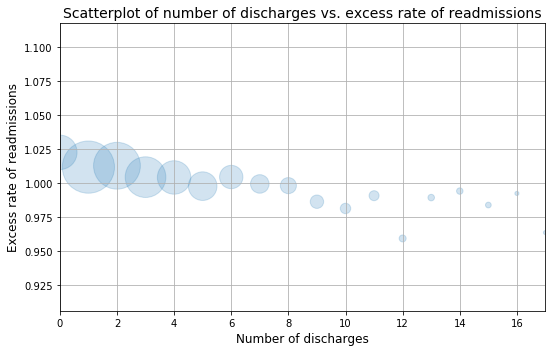

In [207]:
# group hospitals by number of discharges
group_metric = 'Discharges group' 

# create group categories by hundreds of discharges
hospitals_for_groups[group_metric] = hospitals[discharges_metric] // 100
grouped_hospitals = hospitals_for_groups.groupby([group_metric], as_index=False)

# compute mean for each group
group_ratio_mean = grouped_hospitals[ratio_metric].mean()

# get series for each chart dimension
groups_xs = group_ratio_mean[group_metric]
groups_ys = group_ratio_mean[ratio_metric]
groups_sizes = grouped_hospitals.size()

# we want to get rid of the largest groups as they have only few hospitals
large_groups_count = 12

# plot scatter
create_scatter(groups_xs[:-large_groups_count], groups_ys[:-large_groups_count], groups_sizes[:-large_groups_count])
    

We can also visualise the readmission excess rate with a histogram.

In [218]:
def create_histogram(x):
    plot = plt.hist(x, range=[0.5, 1.8])
    plt.xlabel(ratio_metric)
    plt.ylabel('Number of hospitals')
    plt.grid(True)

First visualise the rates for an entire dataset.

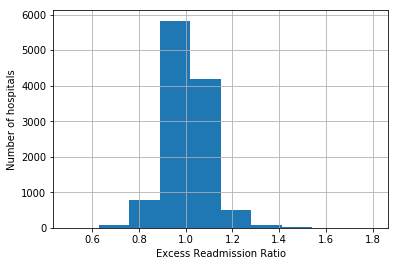

In [219]:
create_histogram(hospitals[ratio_metric])

Then visualise rates just for very small (under 100 discharges) and small hospitals (under 300 discharges).

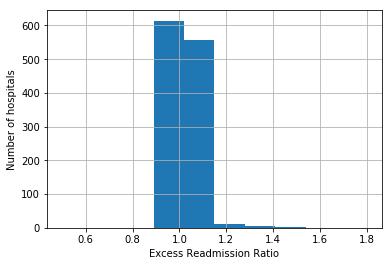

In [220]:
create_histogram(very_small_ys)

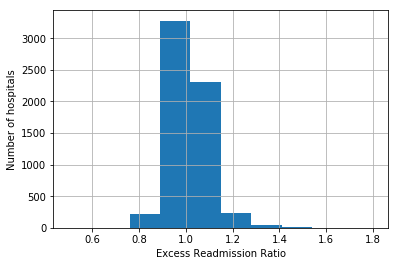

In [221]:
small_ys = small_hospitals[ratio_metric]
create_histogram(small_ys)

Comparing histogram for the entire dataset with histograms of only small hospitals, we can tell that there is a slight trend of smaller hospitals have on average higher excess readmission rates.